## Análisis de las ventas de desodorantes en aerosol 

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
deodorants_df = pd.read_csv("../clean_data/deodorants_final_merged.csv",
                            parse_dates=['fecha_trans'])

In [9]:
deodorants_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8356436 entries, 0 to 8356435
Data columns (total 27 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   idb                     int64         
 1   id_producto             int64         
 2   fecha_trans             datetime64[ns]
 3   stock_unidades          int64         
 4   venta_unidades          int64         
 5   precio_unitario         float64       
 6   sigue_prod_en_rol       int64         
 7   cd_abast                int64         
 8   mov_month               int64         
 9   mov_year                int64         
 10  mov_weekday             int64         
 11  ventas_estimadas_promo  int64         
 12  nro_prom                int64         
 13  duracion_promo          int64         
 14  id_cadena               int64         
 15  desc_cadena             object        
 16  longitud                float64       
 17  latitud                 float64       
 18  lo

### Preguntas

- ¿Cuáles son los productos con mayor volumen de ventas?

In [10]:
product_grouped_top10 = deodorants_df.groupby(
    ['id_producto', 'desc_producto'])['venta_unidades'].sum().sort_values(
        ascending=False).nlargest(10).reset_index()
product_grouped_top10

,id_producto,desc_producto,venta_unidades
0,342686,glade desodorante de ambientes lavander nueva ...,109531
1,240911,poett ambiental lavanda nuevo d 0.377 kg,100861
2,429883,glade desodorante de ambientes ocean oasis nue...,89345
3,249486,glade toque rep lavandax2 9gr/6 lavanda 9 grm,86737
4,342745,glade desodorante de ambientes jazmin nueva fo...,72907
5,228217,glade toque rep limon 12mlx12 repuesto 12 mlt,68809
6,242234,poett ambiental suavidad de algodon nuevo d 0....,68083
7,447299,glade desodorante de ambientes paraiso azul 1 ...,66318
8,292949,glade toque desodorante de ambientes ma�ana ca...,64371
9,242231,poett ambiental primavera nuevo d 0.377 kg,62046


In [11]:
product_grouped_top10['desc_producto']=product_grouped_top10['desc_producto'].replace(to_replace='ma�ana', value='manana', regex=True)

In [12]:
product_grouped_bottom10 = deodorants_df.groupby(
    ['id_producto', 'desc_producto'])['venta_unidades'].sum().sort_values(
        ascending=False).nsmallest(10).reset_index()
product_grouped_bottom10

,id_producto,desc_producto,venta_unidades
0,497936,missing,0
1,511325,missing,1983
2,284013,missing,2562
3,466069,glade toque aromatizante de ambientes campos l...,2812
4,511324,pure aerosol air wick cherry blossom 250.00 mlt,2927
5,511326,air wick pure aerosol soft cotton 250.00 mlt,3063
6,485719,missing,3181
7,284012,air wick citrico full rep.gratis 250.00 mlt,3650
8,415268,freshmatic bosque magico aparato air wick lush...,4169
9,164146,missing,5179


In [13]:
# concatenate the id_producto and desc_producto columns
product_grouped_bottom10['desc_producto'] = product_grouped_bottom10.apply(lambda row: 'id_prod:' + str( row['id_producto']) + ' - ' + row['desc_producto'], axis=1)

In [20]:
def plot_sales_chart(df, title, save_title):
    # set the seaborn theme
    sns.set_style("whitegrid")
    
    # set the color palette
    color = "blend:#7AB,#EDA"
    sns.set_palette(sns.color_palette(color))

    # create the bar plot
    ax = sns.barplot(x="venta_unidades", y="desc_producto", data=df, palette=color)
   
    # add labels to the bars
    for i, v in enumerate(df['venta_unidades']):
        ax.text(v + 1, i, str(v), color='black')

    # set the chart title and labels
    plt.title(title, fontweight='bold', fontsize=14)
    plt.xlabel("Ventas en Unidades", fontsize=10)
    plt.ylabel("Descripción del Producto", fontsize=10)
    
     # save the plot as a PNG file
    plt.savefig(f'images/{save_title}', dpi=300, bbox_inches='tight')

    # show the plot
    plt.show()


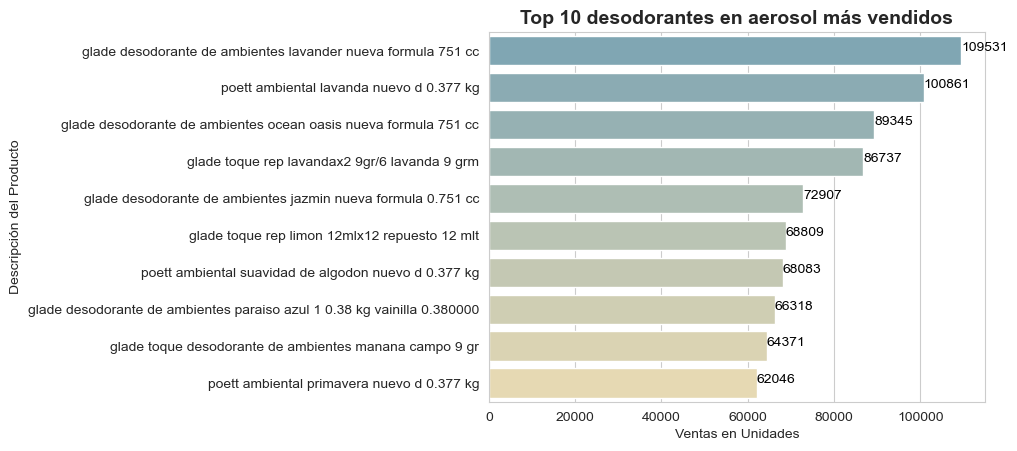

In [21]:
plot_sales_chart(product_grouped_top10,
                 'Top 10 desodorantes en aerosol más vendidos',
                 'ventas_desodorantes_top10')

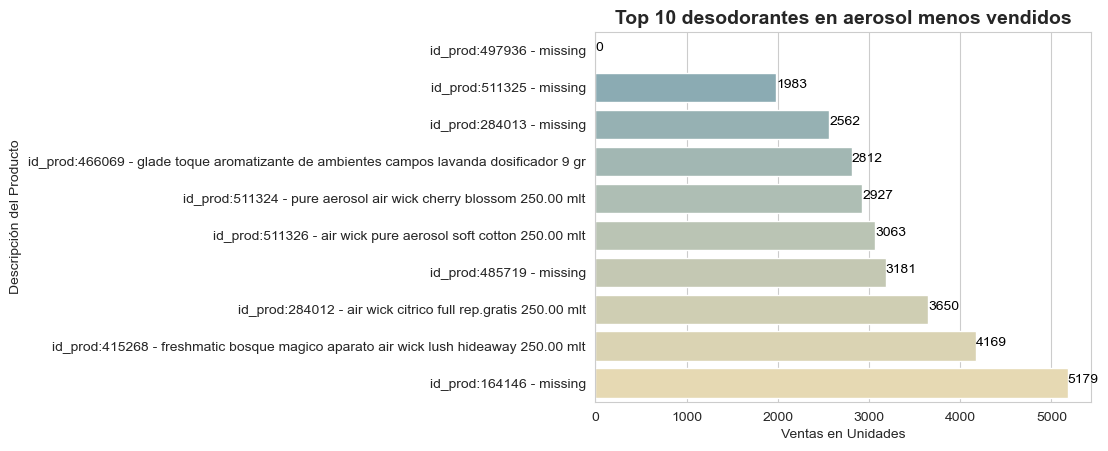

In [22]:
plot_sales_chart(product_grouped_bottom10,
                 'Top 10 desodorantes en aerosol menos vendidos',
                 'ventas_desodorantes_bot10')

Esta lista de 16 productos tienen ventas zero y nunca han tenido una promoción por lo tanto las vamos a eliminar del dataset. 

In [ ]:
# Group the DataFrame by 'id_producto' and 'tiene_promo', and count the number of rows for each group
promo_counts = deodorants_df.groupby(['id_producto', 'tiene_promo'
                                      ]).size().reset_index(name='count')

# Create a Boolean Series indicating if a product has a count for both 'tiene_promo' values
has_both_promos = promo_counts.groupby(
    'id_producto')['tiene_promo'].count() == 2

# Filter the DataFrame to get the products that do not have a count for either 'tiene_promo' value
no_promos = promo_counts[~promo_counts['id_producto'].
                         isin(has_both_promos[has_both_promos].index)]

# Get the unique products IDs that do not have a count for either 'tiene_promo' value
no_promo_products = no_promos['id_producto'].unique()

no_promo_products

In [ ]:
deodorants_without_promo = deodorants_df[deodorants_df['id_producto'].isin(
    no_promo_products)]
deodorants_without_promo

In [ ]:
# filter the dataframe based on venta_unidades == 0
ventas_zero_df = deodorants_df[deodorants_df['venta_unidades'] == 0]

# group the resulting dataframe by id_producto and desc_producto, and sum the units sold
ventas_zero_grouped = ventas_zero_df.groupby(['id_producto', 'desc_producto'
                                              ])['venta_unidades'].sum()

# reset the index to convert the resulting series to a dataframe
ventas_zero_df = ventas_zero_grouped.reset_index()

ventas_zero_df

In [ ]:
# print the resulting dataframe
result = ventas_zero_df[ventas_zero_df['desc_producto']=='unknown']
result

In [ ]:
unknown = deodorants_df['desc_producto']
unknown

In [ ]:
# filter ventas_zero_df based on the condition that id_producto is in no_promo_products list
ventas_zero_in_no_promos = ventas_zero_df[ventas_zero_df['id_producto'].isin(
    no_promo_products)]

# print the resulting dataframe
ventas_zero_in_no_promos

In [ ]:
# create a boolean mask indicating which rows in deodorants_df have an id_producto that is present in ventas_zero_in_no_promos
mask = deodorants_df['id_producto'].isin(
    ventas_zero_in_no_promos['id_producto'])

# create a new dataframe without the rows that meet the condition
deodorants_df_filtered = deodorants_df[~mask]

# print the resulting dataframe
len(deodorants_df_filtered)

In [ ]:
plot_sales_chart(
    product_grouped_top10,
    'Top 10 desodorantes con mayor volumen de ventas desde Julio 2016 hasta Julio 2019',
    'ventas_producto_top10')